In [106]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, rlm
from statsmodels.iolib.summary2 import summary_col


from sklearn.linear_model import Lasso, LassoCV

from patsy import dmatrices
from sklearn_pandas import DataFrameMapper, cross_val_score
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics

In [152]:


degree_vars = ['user1_degree_total',
           'user1_degree_incoming', 'user1_degree_outgoing',]

graph_vars=       ['user1_clustering_coefficient',
           'user1_closeness_centrality_unweighted',
           'user1_closeness_centrality_incoming_unweighted',
           'user1_closeness_centrality_outgoing_unweighted']

satoshi_vars=       ['user1_satoshi_distance',
            'user1_satoshi_pagerank_weighted',
            'user1_satoshi_distance_inf']

weighted_vars=       [ 'user1_pagerank_weighted', 'user1_betweenness_centrality_weighted',
           'user1_closeness_centrality_weighted','user1_closeness_centrality_incoming_weighted',
           'user1_closeness_centrality_outgoing_weighted']

naive_vars = ['user1_num_posts', 'user1_num_subjects',
           'user1_days_since_first_post',
           'technical']
independent_vars =  naive_vars + graph_vars + satoshi_vars + weighted_vars + degree_vars
dependent_vars = ["log_volume","log_severity","market_num"]

In [153]:
def joint_dataset(fname):
    data = pd.read_csv( fname, 
    index_col='coin').join(pd.read_csv(
        'types.csv',index_col='coin')).join(pd.read_csv(
        'coinmarketanalisis.csv',index_col='coin',skipinitialspace=True))
    data['user1_years_since_first_post'] = data.user1_days_since_first_post/365.
    data['log_severity']=np.log(data['severity_to_average_after_max_volume_weighted'])
    data['log_volume']=np.log(data['total_volume'])

    data.loc[data.user1_satoshi_distance > 6,'user1_satoshi_distance_inf'] = 1
    data.loc[data.user1_satoshi_distance <= 6,'user1_satoshi_distance_inf'] = 0
    data.loc[data.user1_satoshi_distance > 6,'user1_satoshi_distance'] = 7 # the infs turn into 7s (highest is 6, there is only one)

    data.loc[data.type == 't','technical'] = 1
    data.loc[data.type == 'nt','technical'] = 0

    #the candidate features we will be using inthe analysis as our indepedent variables


    df= data[independent_vars+dependent_vars]

    data_norm = (df - df.mean()) / (df.std())
    return data_norm


In [157]:
#model_aic = LassoLarsIC(criterion='aic')
#model_aic.fit(np.array(X), np.array(y))
#print sm.OLS(y,X).fit(cov_type='HC3').summary() 

def CVregularizedRobustErrorsLS(target,xvars,data_norm ):
    formula = target + " ~ " + " + ".join(xvars)
    y,X = dmatrices(formula ,data_norm,return_type='dataframe' )
    X = sklearn.preprocessing.scale(X)
    y = sklearn.preprocessing.scale(y[target])
    reg_para = [0.0001,0.001, 0.0025,0.005,0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.5, 1, 5, 10, 50, 100]
    lasso_model = LassoCV(cv=10 , alphas=reg_para, selection='random')
    lasso_fit = lasso_model.fit(X,y)
    #print lasso_fit. alpha_,lasso_fit.coef_
    selected = ["1"]
    for i,x in enumerate(lasso_fit.coef_[1:]): #skip the constant
        if x != 0.: selected.append(xvars[i])
    #return  ols(target + " ~ " + " + ".join(selected) ,data_norm).fit(cov_type='HC0')
    return  ols(target + " ~ " + " + ".join(selected) ,data_norm).fit_regularized( L1_wt=0.99, alpha=0.01)

1- unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv:
Contains graph measures for users who initiated a new thread which mentioned both
unmodified coin name and symbol along with [ANN] string, all in the subject of the thread
for the first time.

2- unmodified_symbol_and_name_in_subject_first_thread_post_introducers_metrics.csv:
Contains graph measures for users who initiated a new thread which mentioned both unmodified coin name
and symbol in the subject of the thread for the first time.

3- unmodified_symbol_and_name_in_subject_or_content_first_thread_post_introducers_metrics.csv:
Contains graph measures for users who initiated a new thread which mentioned both
unmodified coin name and symbol in the subject or content of the post for the first time.

4- unmodified_symbol_and_name_in_subject_or_content_first_introducers_metrics.csv:
Contains graph measures for users who mentioned both unmodified coin name and symbol in
the subject or content of any post for the first time.


In [158]:

def make_regression_tables(yvar,datasets):
    for f in l:
        data_norm = joint_dataset(f)
        reg3 =  CVregularizedRobustErrorsLS(yvar,independent_vars, data_norm)
        reg2 =  CVregularizedRobustErrorsLS(yvar,naive_vars  + degree_vars + graph_vars + graph_vars ,data_norm)
        reg1 =  CVregularizedRobustErrorsLS(yvar,naive_vars + degree_vars,data_norm)
        reg0 = CVregularizedRobustErrorsLS(yvar,naive_vars,data_norm)


        res = summary_col([reg0,reg1,reg2,reg3],stars=True,float_format='%0.2f',
                      model_names=['User','Node','Graph','Satoshi'],
                      info_dict={#'N':lambda x: "{0:d}".format(int(x.nobs)),
                                 'R2':lambda x: "{:.2f}".format(x.rsquared),
                                 'Adjusted-R2':lambda x: "{:.2f}".format(x.rsquared_adj),
                                 'AIC':lambda x: "{:.2f}".format(x.aic),
                                 'BIC':lambda x: "{:.2f}".format(x.bic),
                                 'Condition Number':lambda x: "{:.2f}".format(x.condition_number) })
        print "\n\n\n",yvar,"N",reg3.nobs, f, 
        print res
        open("tables/"+yvar +"_models "+ f[25:-4]+".tex","w").write(res.as_latex())
    return True

In [159]:



l= ["directed_unlimited/unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv",
    "directed_unlimited/unmodified_symbol_and_name_in_subject_or_content_first_introducers_metrics.csv",
    "directed_unlimited/unmodified_symbol_and_name_in_subject_first_thread_post_introducers_metrics.csv",
    "directed_unlimited/unmodified_symbol_and_name_in_subject_or_content_first_thread_post_introducers_metrics.csv"]

make_regression_tables("log_volume",l)
make_regression_tables("log_severity",l)
make_regression_tables("market_num",l)





log_volume N 279.0 directed_unlimited/unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv 
                                                 User    Node   Graph  Satoshi 
-------------------------------------------------------------------------------
Intercept                                      0.00    0.00    0.00    0.00    
                                               (0.00)  (0.00)  (0.00)  (0.00)  
technical                                      0.21*** 0.21*** 0.18*** 0.18*** 
                                               (0.06)  (0.06)  (0.05)  (0.05)  
user1_closeness_centrality_outgoing_unweighted                 0.32*** 0.28    
                                                               (0.06)  (805.24)
user1_closeness_centrality_outgoing_weighted                           0.02    
                                                                       (805.24)
user1_clustering_coefficient                                   -0.0

True

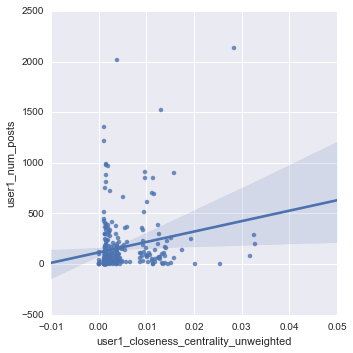

In [10]:
sns.lmplot('user1_closeness_centrality_unweighted','user1_num_posts',data)

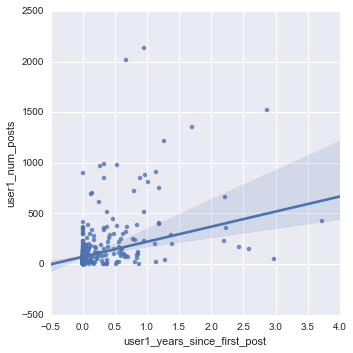

In [192]:
sns.lmplot('user1_years_since_first_post','user1_num_posts',data,robust=True)

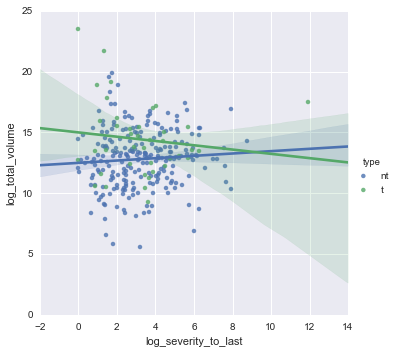

In [117]:
sns.lmplot("log_severity", "log_volume",data,hue='type')

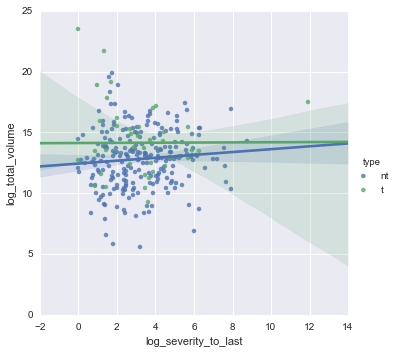

In [131]:
sns.lmplot("log_severity_to_last", "log_total_volume",data,hue='type', robust=True)

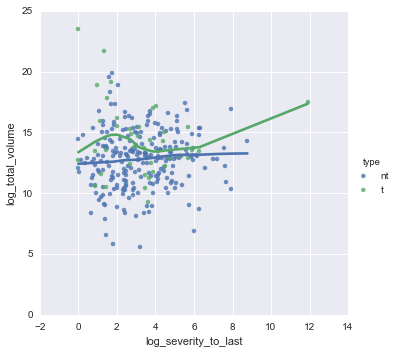

In [132]:
sns.lmplot("log_severity_to_last", "log_total_volume",data,hue='type', lowess=True)

In [133]:
data.finite_satoshi_distance.describe()

count    315
mean       0
std        0
min        0
25%        0
50%        0
75%        0
max        0
Name: finite_satoshi_distance, dtype: float64

[ 0.          0.15250966 -0.07664682 -0.09524955  0.          0.          0.0558316
 -0.         -0.          0.          0.          0.          0.25463985
  0.          0.         -0.         -0.          0.          0.        ] 0.05


Average out of sample score on cross validation 0.054735


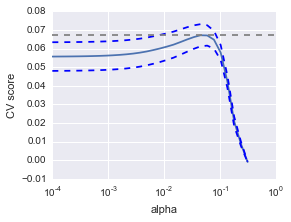

In [228]:
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')


lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 5)
scores=[]
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    s=lasso_cv.score(X[test], y[test])
    scores.append(s)
print "Average out of sample score on cross validation %f"% np.average(scores)


Average out of sample score on cross validation 0.058798


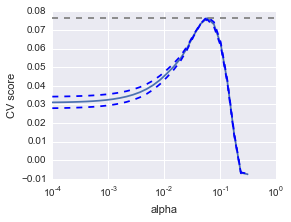

In [229]:
from sklearn import cross_validation, linear_model
import matplotlib.pyplot as plt
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(4, 3))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')


lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 5)
scores=[]
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    s=lasso_cv.score(X[test], y[test])
    scores.append(s)
print "Average out of sample score on cross validation %f"% np.average(scores)


In [41]:
from sklearn.grid_search import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

clf = RandomForestRegressor(n_estimators=20)
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])



# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, None],
              "max_features": sp_randint(1, len(X[1])),
              "min_samples_split": sp_randint(1, len(X[1])),
              "min_samples_leaf": sp_randint(1, len(independent_vars)),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 0.78 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.048 (std: 0.005)
Parameters: {'max_features': 2, 'min_samples_split': 2, 'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 22}

Model with rank: 2
Mean validation score: 0.037 (std: 0.011)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 46}

Model with rank: 3
Mean validation score: 0.028 (std: 0.029)
Parameters: {'max_features': 5, 'min_samples_split': 4, 'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 9}



In [43]:
from sklearn.grid_search import  RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

clf = RandomForestRegressor(n_estimators=20)
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])



# specify parameters and distributions to sample from
param_dist = {"max_depth": [2, None],
              "max_features": sp_randint(1, len(X[1])),
              "min_samples_split": sp_randint(1, len(X[1])),
              "min_samples_leaf": sp_randint(1, len(independent_vars)),
              "bootstrap": [True, False]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

RandomizedSearchCV took 0.97 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.098 (std: 0.059)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.096 (std: 0.067)
Parameters: {'max_features': 3, 'min_samples_split': 1, 'bootstrap': False, 'max_depth': 2, 'min_samples_leaf': 39}

Model with rank: 3
Mean validation score: 0.083 (std: 0.122)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5}



MSE: 0.7880


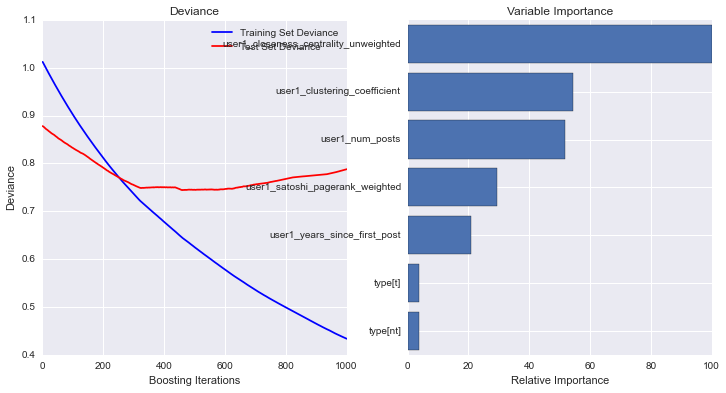

In [85]:




from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

###############################################################################
y,X = dmatrices("log_severity ~ 0+  " + independent_vars ,data,return_type='dataframe' )
feature_names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 1,
          'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


# this may take some minutes
#gs_cv = GridSearchCV(ensemble.GradientBoostingRegressor, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
#print gs_cv.best_params_


###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

MSE: 0.8339


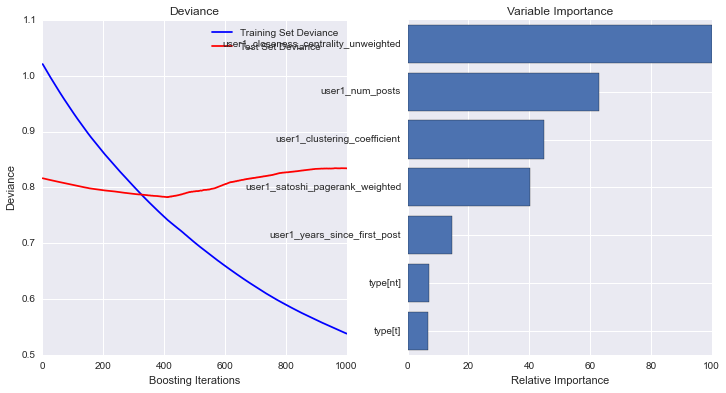

In [87]:




from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

###############################################################################
y,X = dmatrices("log_volume ~ 0+  " + independent_vars ,data,return_type='dataframe' )
feature_names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_volume'])
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 1,
          'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)


# this may take some minutes
#gs_cv = GridSearchCV(ensemble.GradientBoostingRegressor, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
#print gs_cv.best_params_


###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Automatically created module for IPython interactive environment
________________________________________________________________________________
Training GBRT...
done.
________________________________________________________________________________
Convenience plot with ``partial_dependence_plots``

________________________________________________________________________________
Custom 3d plot via ``partial_dependence``



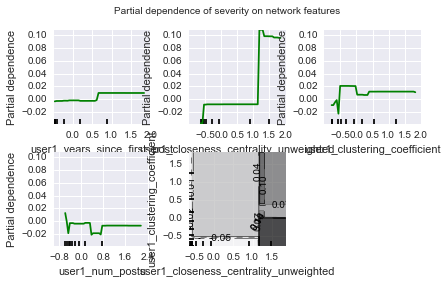

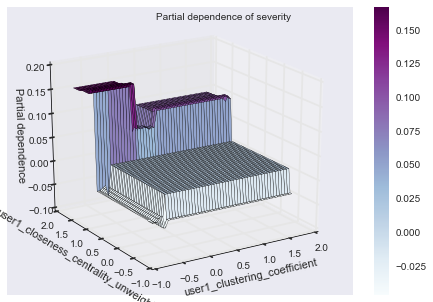

In [82]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.datasets.california_housing import fetch_california_housing



y,X = dmatrices("log_severity ~   " + independent_vars ,data,return_type='dataframe' )
names = X.columns
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y['log_severity'])
offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# split 80/20 train-test

print('_' * 80)
print("Training GBRT...")
clf = GradientBoostingRegressor(n_estimators=10, max_depth=6,
                                learning_rate=0.01, loss='ls',
                                random_state=1)
clf.fit(X_train, y_train)
print("done.")

print('_' * 80)
print('Convenience plot with ``partial_dependence_plots``')
print

features = [3, 5, 4, 2, (5, 4)]
fig, axs = plot_partial_dependence(clf, X_train, features, feature_names=names,
                                   n_jobs=3, grid_resolution=50)
fig.suptitle('Partial dependence of severity on network features')
plt.subplots_adjust(top=0.9)  # tight_layout causes overlap with suptitle

print('_' * 80)
print('Custom 3d plot via ``partial_dependence``')
print
fig = plt.figure()

target_feature = (4, 5)
pdp, (x_axis, y_axis) = partial_dependence(clf, target_feature,
                                           X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=-122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of severity')
plt.subplots_adjust(top=0.9)

plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

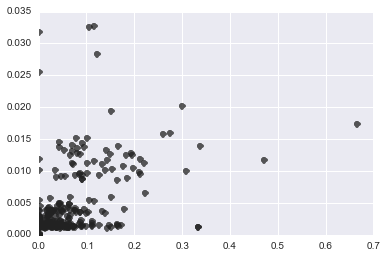

In [75]:
sns.interactplot('user1_clustering_coefficient','user1_closeness_centrality_unweighted', 'log_severity', data=data)

ValueError: zero-size array to reduction operation minimum which has no identity

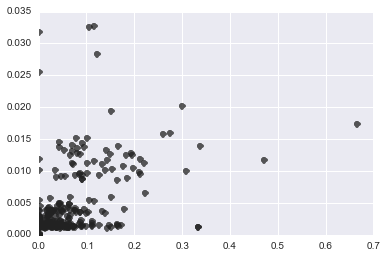

In [77]:
sns.interactplot('user1_clustering_coefficient','user1_closeness_centrality_unweighted', 'log_volume', data=data)

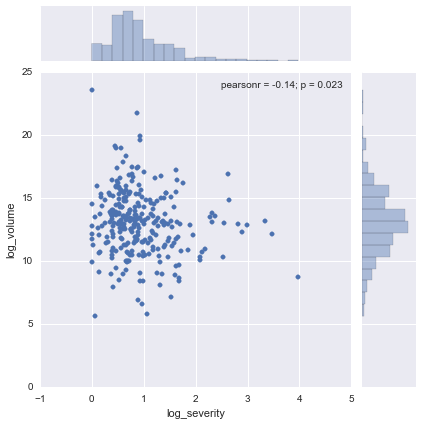

In [81]:
sns.jointplot(x="log_severity", y="log_volume", data=data);

AttributeError: max must be larger than min in range parameter.

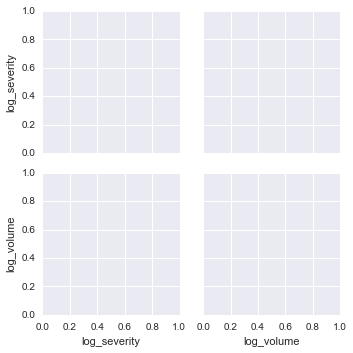

In [89]:
sns.pairplot(data[['log_severity','log_volume']])

AttributeError: max must be larger than min in range parameter.

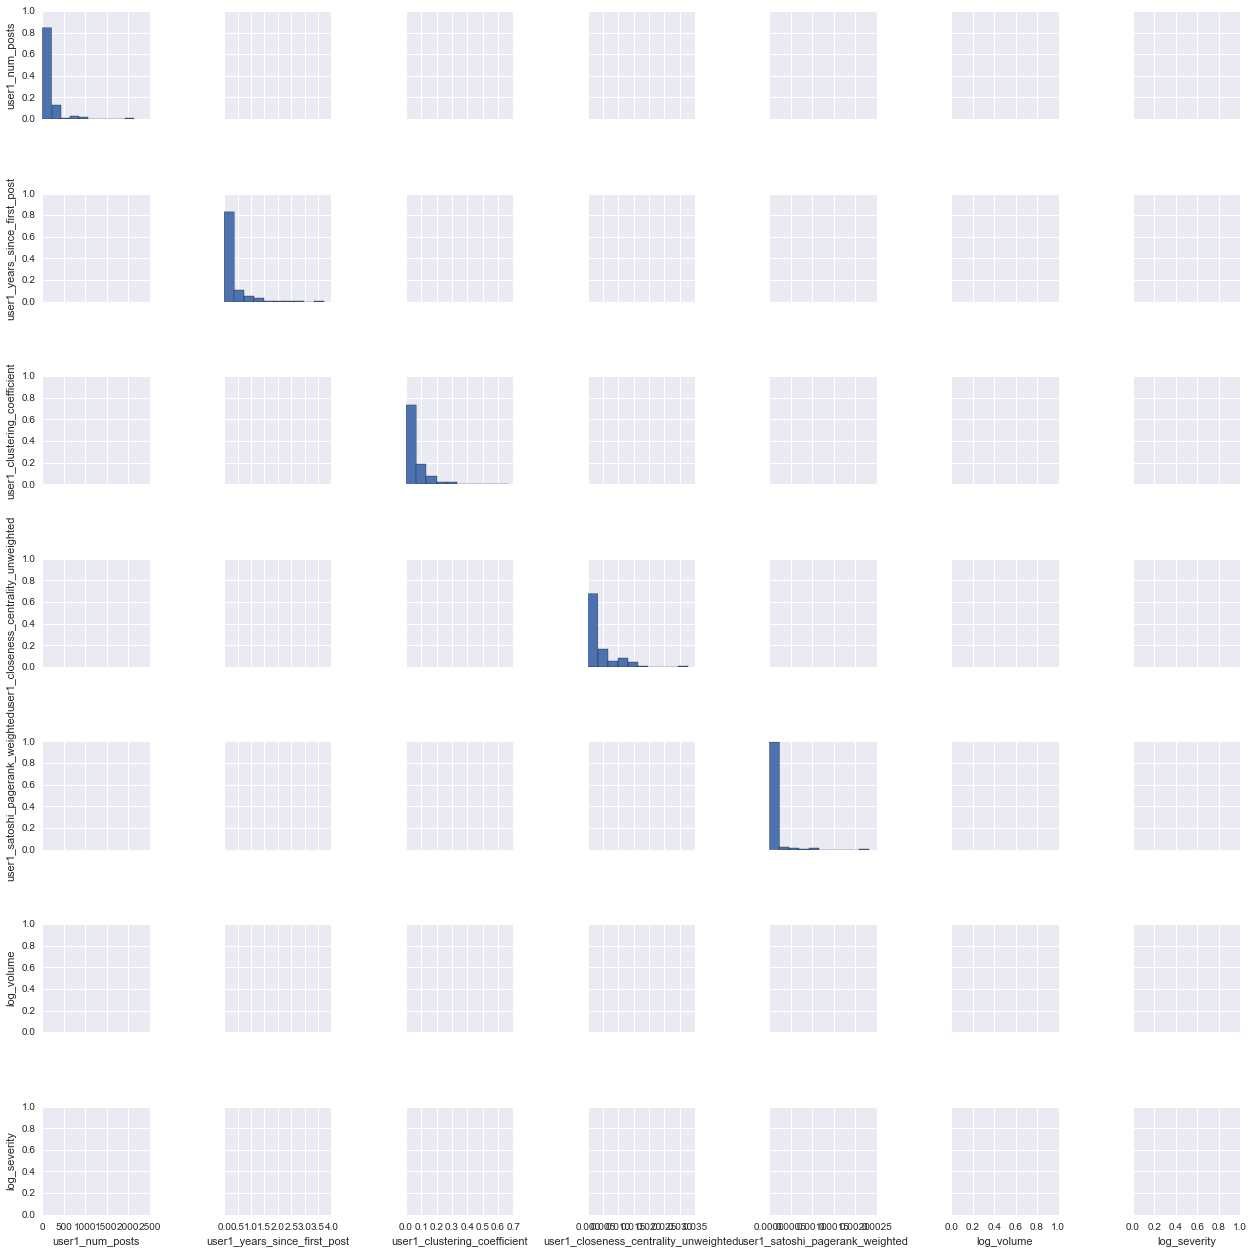

In [97]:
sns.pairplot(tight_dataset)

In [125]:
factor(data.user1_satoshi_distance)

KeyError: <pandas.core.indexing._LocIndexer object at 0x1117b4cd0>

In [151]:
data['user1_num_mentions'].describe()

count    315
mean       1
std        0
min        1
25%        1
50%        1
75%        1
max        1
Name: user1_num_mentions, dtype: float64

In [179]:
"np.log(total_volume) ~ " + " + ".join(independent_vars)

u'np.log(total_volume) ~ user1_num_posts + user1_num_subjects + user1_days_since_first_post + user1_degree_total + user1_degree_incoming + user1_degree_outgoing + user1_clustering_coefficient + user1_closeness_centrality_unweighted + user1_closeness_centrality_weighted + user1_closeness_centrality_incoming_unweighted + user1_closeness_centrality_outgoing_unweighted + user1_closeness_centrality_incoming_weighted + user1_closeness_centrality_outgoing_weighted + user1_betweenness_centrality_weighted + user1_satoshi_distance + user1_satoshi_pagerank_weighted + user1_pagerank_weighted + type'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15fefcfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a351a650>]], dtype=object)

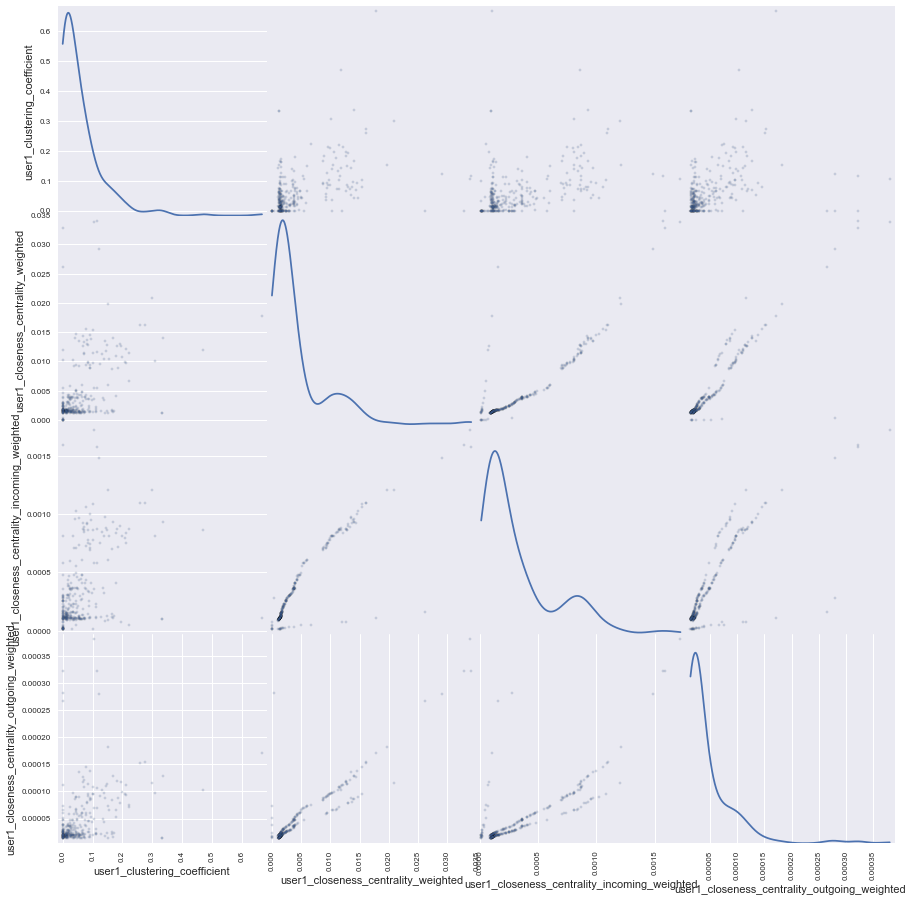

In [221]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(data[[
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_weighted',
       u'user1_closeness_centrality_incoming_weighted',
       u'user1_closeness_centrality_outgoing_weighted']], alpha=0.2, figsize=(15, 15), diagonal='kde')



In [76]:
pd.read_csv(
    "directed_unlimited/unmodified_symbol_and_name_in_subject_with_[ANN]_first_thread_post_introducers_metrics.csv")

,coin,earliest_trade_date,network_date,user1,user1_num_mentions,user1_num_posts,user1_num_subjects,user1_days_since_first_post,user1_degree_total,user1_degree_incoming,...,user1_closeness_centrality_unweighted,user1_closeness_centrality_weighted,user1_closeness_centrality_incoming_unweighted,user1_closeness_centrality_outgoing_unweighted,user1_closeness_centrality_incoming_weighted,user1_closeness_centrality_outgoing_weighted,user1_betweenness_centrality_weighted,user1_satoshi_distance,user1_satoshi_pagerank_weighted,user1_pagerank_weighted
0,AXR,2014-08-27,2014-08-15,Project Axron,1,118,1,1,0,0,...,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.00000,inf,8.798088e-07,0.000004
1,NYAN,2014-02-09,2013-12-22,myhoho,1,169,6,889,131,45,...,0.004815,0.004836,0.000478,0.000061,0.000478,0.000061,96677.18000,3.000000,3.988759e-05,0.000088
2,WDC,2013-05-22,2013-05-15,WorldCoin,1,12,2,1,52,52,...,0.013346,0.013481,0.000970,0.000087,0.000971,0.000087,0.00000,3.000000,8.662738e-05,0.000257
3,TIX,2013-11-03,2013-09-21,Lottery Tickets,1,193,4,1,47,47,...,0.009346,0.009417,0.000738,0.000061,0.000738,0.000061,0.00000,3.000000,4.129018e-05,0.000122
4,CKC,2014-09-19,2014-07-30,BitsendInc,1,74,1,1,17,17,...,0.001444,0.001446,0.000113,0.000016,0.000113,0.000016,0.00000,4.000000,4.775633e-06,0.000017
5,CANN,2014-08-02,2014-04-21,CannabisCoinDev,1,189,13,18,29,29,...,0.001653,0.001655,0.000163,0.000020,0.000163,0.000020,0.00000,4.000000,6.244498e-06,0.000020
6,GSX,2014-11-23,2014-11-11,glowshares,1,50,1,1,15,15,...,0.001251,0.001252,0.000100,0.000015,0.000100,0.000015,0.00000,4.000000,2.122413e-06,0.000008
7,DRS,2014-06-15,2014-05-02,Nthused,1,988,16,122,206,63,...,0.001643,0.001645,0.000148,0.000026,0.000148,0.000026,963583.90000,3.000000,1.760120e-05,0.000045
8,DIEM,2014-04-28,2014-03-14,Carpe Diem Coin,1,352,11,1,33,32,...,0.001875,0.001878,0.000199,0.000030,0.000199,0.000030,76843.84000,4.000000,2.497634e-05,0.000092
9,HVC,2014-03-12,2014-03-09,keccak512,1,242,2,294,442,436,...,0.001958,0.001961,0.000207,0.000030,0.000207,0.000030,2066649.00000,3.000000,3.200175e-04,0.001113


                            OLS Regression Results                            
Dep. Variable:             log_volume   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.166
Date:                Wed, 14 Oct 2015   Prob (F-statistic):             0.0249
Time:                        14:52:56   Log-Likelihood:                -660.45
No. Observations:                 283   AIC:                             1329.
Df Residuals:                     279   BIC:                             1343.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
In

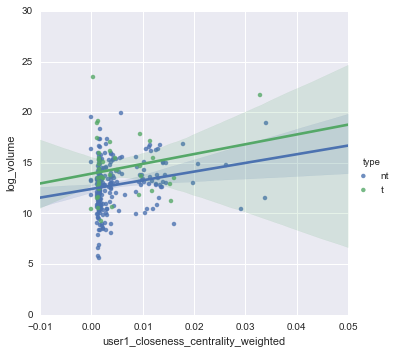

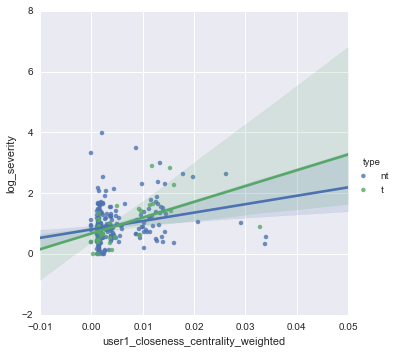

In [163]:
print ols(formula="log_volume ~ user1_closeness_centrality_weighted+ user1_satoshi_distance + user1_satoshi_distance_inf" ,data=data).fit(cov_type='HC3').summary()
print ols(formula="log_severity ~ user1_closeness_centrality_weighted + user1_satoshi_distance + user1_satoshi_distance_inf" ,data=data).fit(cov_type='HC3').summary() 
print ols(formula="log_severity ~ user1_closeness_centrality_weighted*type" ,data=data).fit(cov_type='HC3').summary() 

sns.lmplot('user1_closeness_centrality_weighted','log_volume',data, hue='type')
sns.lmplot('user1_closeness_centrality_weighted','log_severity',data, hue='type')

In [224]:
data.columns

Index([u'earliest_trade_date', u'network_date', u'user1',
       u'user1_num_mentions', u'user1_num_posts', u'user1_num_subjects',
       u'user1_days_since_first_post', u'user1_degree_total',
       u'user1_degree_incoming', u'user1_degree_outgoing',
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_unweighted',
       u'user1_closeness_centrality_weighted',
       u'user1_closeness_centrality_incoming_unweighted',
       u'user1_closeness_centrality_outgoing_unweighted',
       u'user1_closeness_centrality_incoming_weighted',
       u'user1_closeness_centrality_outgoing_weighted',
       u'user1_betweenness_centrality_weighted', u'user1_satoshi_distance',
       u'user1_satoshi_pagerank_weighted', u'user1_pagerank_weighted', u'name',
       u'type', u'subcategory', u'max_price', u'min_price',
       u'severity_to_min_price', u'severity_to_min_price_after_max',
       u'severity_to_last', u'severity_to_average',
       u'severity_to_average_after_max',
      

In [4]:
from statsmodels.sandbox import gam

/Users/nikete/anaconda/lib/python2.7/site-packages/statsmodels/sandbox/gam.py:328: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


/Users/nikete/anaconda/lib/python2.7/site-packages/statsmodels/sandbox/gam.py:328: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)
/Users/nikete/anaconda/lib/python2.7/site-packages/statsmodels/sandbox/gam.py:328: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


normal


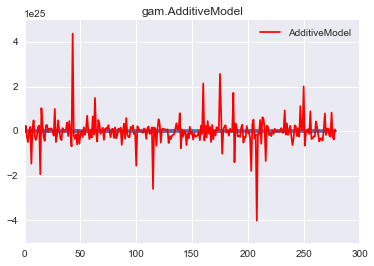

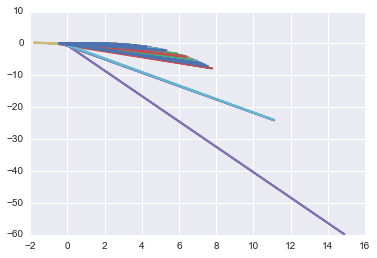

In [21]:

example = 1  # 1,2 or 3

import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

from statsmodels.sandbox.gam import AdditiveModel
from statsmodels.sandbox.gam import Model as GAM #?
from statsmodels.genmod.families import family
from statsmodels.genmod.generalized_linear_model import GLM

standardize = lambda x: (x - x.mean()) / x.std()
demean = lambda x: (x - x.mean())
target = 'log_volume'
y,X = dmatrices(target +" ~ " + " + ".join(independent_vars) ,data,return_type='dataframe' )
X = sklearn.preprocessing.scale(X)
y = sklearn.preprocessing.scale(y[target])
g= gam.AdditiveModel(X)
g.fit(y)


if example == 1:
    print("normal")
    m = AdditiveModel(X)
    m.fit(y)
    x = np.linspace(-2,2,50)

    print(m)

    y_pred = m.results.predict(X)
    plt.figure()
    plt.plot(y, '.')
    plt.plot(y_pred, 'r-', label='AdditiveModel')
    plt.legend()
    plt.title('gam.AdditiveModel')

import scipy.stats, time

if example == 2:
    print("binomial")
    f = family.Binomial()
    b = np.asarray([scipy.stats.bernoulli.rvs(p) for p in f.link.inverse(y)])
    b.shape = y.shape
    m = GAM(b, d, family=f)
    toc = time.time()
    m.fit(b)
    tic = time.time()
    print(tic-toc)


if example == 3:
    print("Poisson")
    f = family.Poisson()
    y = y/y.max() * 3
    yp = f.link.inverse(y)
    p = np.asarray([scipy.stats.poisson.rvs(p) for p in f.link.inverse(y)], float)
    p.shape = y.shape
    m = GAM(p, d, family=f)
    toc = time.time()
    m.fit(p)
    tic = time.time()
    print(tic-toc)


plt.figure()
plt.plot(X, standardize(m.smoothers[0](X)), 'r')
plt.plot(X, standardize(f1(X)), linewidth=2)
plt.figure()
#plt.plot(x2, standardize(m.smoothers[1](x2)), 'r')
#plt.plot(x2, standardize(f2(x2)), linewidth=2)


In [22]:
[1,2]+[1,5,34,5]

[1, 2, 1, 5, 34, 5]

In [24]:
data.columns

Index([u'earliest_trade_date', u'network_date', u'user1',
       u'user1_num_mentions', u'user1_num_posts', u'user1_num_subjects',
       u'user1_days_since_first_post', u'user1_degree_total',
       u'user1_degree_incoming', u'user1_degree_outgoing',
       u'user1_clustering_coefficient',
       u'user1_closeness_centrality_unweighted',
       u'user1_closeness_centrality_weighted',
       u'user1_closeness_centrality_incoming_unweighted',
       u'user1_closeness_centrality_outgoing_unweighted',
       u'user1_closeness_centrality_incoming_weighted',
       u'user1_closeness_centrality_outgoing_weighted',
       u'user1_betweenness_centrality_weighted', u'user1_satoshi_distance',
       u'user1_satoshi_pagerank_weighted', u'user1_pagerank_weighted', u'name',
       u'type', u'subcategory', u'max_price', u'min_price',
       u'severity_to_min_price', u'severity_to_min_price_after_max',
       u'severity_to_last', u'severity_to_average',
       u'severity_to_average_after_max',
      

In [122]:
lasso_fit = lasso_model.fit(X,y)

NameError: name 'lasso_model' is not defined